## Visualizing Classification Results: Confusion Star and Confusion Gear
*Amalia Luque, Mirko Mazzoleni, Alejandro Carrasco and Antonio Ferramosca*



**Notebook to visualize a Confusion Matrix**

It contains the following 2 principal functions:
*   PlotConfusionStar
> Plot a confusion star (or a confusion gear)
*   VideoConfusionStar
> Generate a video file visualizing a sequence of confusion matrices in the form of confusion stars (or confusion gears)

To get examples of confusion matrices 2 additional functions are provided:
*   GetConfusionMatrix
> Reads an Excel file containing a confusion matrix
*   GetSequenceConfusionMatrices
> Reads an Excel file containing a sequence of confusion matrices


All the examples are based on simple classifiers applied to:
*   The MNIST dataset
*   A 10-class reduced version of the Abalone dataset
*   The CIFAR-100 dataset

**Required files**

The following files are required:
*   MNIST_cm.xlsx
*   Abalone-10_cm.xlsx
*   CIFAR-100_cm.xlsx
*   MNIST_cm_sequence.xlsx

# Get a confusion matrix

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [2]:
def GetConfusionMatrix(filename):
    '''Reads an Excel file containing a confusion matrix
    Parameters
    ----------
    filename : str
        The name of the file. 
        It has to be an excel file with the following structure:
            - The first row indicates the names of the estimated classes
            - The first column indicates the names of the actual classes
            - The remaining elemnts contains de confusion matrix

    Returns
    -------
    cm : confusion matrix of dimension (C,C)
    cl: Vector of dimension C
        The labels of the classes
    '''    
    df = pd.read_excel(filename, index_col=0)
    cm = df.values
    cl = df.columns.values
    return cm,cl

In [3]:

file = 'MNIST_cm.xlsx'
cm,cl = GetConfusionMatrix(file)
print(cm)

[[700   1   9  12   0 214  20  20   3   1]
 [  1 995   4  15   0   1   8   2 108   1]
 [ 67 184 468  38  10  52  14 152  38   9]
 [102  42  20 674   1  76   6  43  41   5]
 [  1   0   0   7 652  10  40  50  48 174]
 [ 65  13  16  47  18 608  38  15  63   9]
 [ 27   0   1   1   1 104 742  29  28  25]
 [  1  25  24  13  31   1   6 880   5  42]
 [  7  52   7  24  11  95  32  11 701  34]
 [  5   1   0  18 156  17  15 127  34 636]]


# Define the principal function (level 1) to plot a confusion matrix

In [4]:
def PlotConfusionStar(cm,cl,star=True,balanced=True,log=False,fill=True,
                      edgecolor=None,outerlabel=True,innerlabel=True,
                      rotoutlabel=False,rotinnlabel=False):
    '''Plot a confusion star (or a confusion gear).
    Parameters
    ----------
    cm : confusion matrix of dimension (C,C)
    cl: Vector of dimension C
        The labels of the classes
    star: bool (optional). A flag used to indicate the type of plot
        if True it plots a confusion star
        if False it plots a confusion gear
    balanced: bool (optional).
        A flag used to indicate if the balanced version of the
        confusion star has to be drawn
    log: bool (optional). A flag used to indicate the scale of the plot.
        It only applies to confusion star plots (not to confusion gear plots)
        if True it uses log scale
        if False it uses linear scale
    fill: bool (optional).
        If True the sectors are filled
    edgecolor: color specification or None.
        Star edge color
    outerlabel: bool (optional).
        If True the label of actual classes are drawn
    innerlabel: bool (optional).
        If True the label of indices to estimated classes are drawn
    rotoutlabel: bool (optional).
        If True the label of actual classes are rotated
    rotinnlabel: bool (optional).
        If True the label of indices to estimated classes are rotated
    '''    
    em,th,beta = GetConfusionStar(cm,balanced)
    PlotConfusionGrid(em,th,cl,star,log,outerlabel,innerlabel,
                      rotoutlabel,rotinnlabel)
    sectors = GetConfusionSectors(em,th,beta,star,log,fill)
    PlotConfusionSectors(sectors,edgecolor)

# Define the auxiliary functions (level 2) required to plot a confusion matrix

This functtions are:
*   GetConfusionStar
*   PlotConfusionGrid
*   GetConfusionSectors
*   PlotConfusionSectors

In [5]:
def GetConfusionStar(cm,balanced):
    '''Obtains the structure of the confusion star (or a confusion gear)
    Parameters
    ----------
    cm : confusion matrix of dimension (C,C)
    balanced: bool (optional).
        A flag used to indicate if the balanced version of the
        confusion star has to be drawn

    Returns
    -------
    em : error matrix of dimension (C,C-1)
        It is a confusion matrix with redundancies (diagonal) removed
    th : Vector of dimension C·(C-1)
        Angles of the sectors in the radial plot
    beta : Vector of dimension C
        Angles where starts each actual class in the radial plot
    '''    
    C = cm.shape[0] #Number of classes
    um = cm2um(cm,unit=True) #Convert to unit matrix if required
    em = um2em(um) #Convert to error matrix
    
    #Compute beta: the angle where starts each actual class
    if balanced:
        beta = np.cumsum(2*np.pi/C*np.ones(C)) #Equally spaced classes
    else:
        m = np.sum(cm,axis=1) #Number of instances per class
        M = np.sum(m) #Total number of instances
        beta = np.cumsum(2*np.pi*m/M) #Proportional to #of instances per class
    beta = np.insert(beta,0,0)

    #Compute th: the angle where starts each index in each actual class
    nth = (C-1)*C
    th = np.zeros(nth)
    for k in np.arange(nth):
        i = int(k/(C-1))
        j = k-i*(C-1)
        dth = (beta[i+1]-beta[i]) / (C-1)
        th[k] = beta[i]+j*dth
    return em,th,beta


def PlotConfusionGrid(em,th,cl,star,log,outerlabel,innerlabel,
                      rotoutlabel,rotinnlabel):
    '''Draw the grid of the confusion star (or a confusion gear)
        This grid includes:
            - The radial grid (circles)
            - A text with the values (scale) corresponding to each circle
            - The angular grid (radii)
            - A text with the class associated to each sector 
                (drawn in the outermost circle)
            - A text with the class associated to each actual class 
                (drawn in the outermost circle, beyond the sector text)
            
    Parameters
    ----------
    em : error matrix of dimension (C,C-1)
        It is a confusion matrix with redundancies (diagonal) removed
    th : Vector of dimension C·(C-1)
        Angles of the sectors in the radial plot
    cl: Vector of dimension C
        The labels of the classes
    star: bool. A flag used to indicate the type of plot
        if True it plots a confusion star
        if False it plots a confusion gear
    log: bool. A flag used to indicate the scale of the plot.
        It only applies to confusion star plots (not to confusion gear plots)
        if True it uses log scale
        if False it uses linear scale
    outerlabel: bool.
        If True the label of actual classes are drawn
    innerlabel: bool.
        If True the label of indices to estimated classes are drawn
    rotoutlabel: bool.
        If True the label of actual classes are rotated
    rotinnlabel: bool.
        If True the label of indices to estimated classes are rotated
    '''    
    #Compute radial grid: position (rgv), position of the text (rgvt) &
                        # format of the text (FormTgrid)
    if star: #Grid for the confusion star
        r = em #Radii vector
        if log: #Confusion star with log scale
            rmin = 0.01
            r = np.log10(np.maximum(rmin,r))-np.log10(rmin)
            rmax = 4
            rgvt = np.asarray([0.1,1,10,100])
            rgv = np.log10(np.maximum(rmin,rgvt))-np.log10(rmin)
            FormTgrid = ['{:2.1f}','{:3.0f}','{:3.0f}','{:3.0f}']
        else: #Confusion star with linear scale
            rmax = np.max(r)
            rmax = 4*np.ceil(rmax/4)
            rgvt = rmax/4*np.asarray([1,2,3,4])
            rgv = rgvt
            FormTgrid = ['{:3.0f}']*4
    else: #Grid for the confusion gear (always linear scale)
        r = 100-em
        rmax = 100
        rgvt = np.asarray([25,50,75,100])
        rgv = rgvt
        FormTgrid = ['{:3.0f}']*4

    #Plot the angular grid (radii)
    C = em.shape[0]
    for i in range(C):
        k = i*(C-1)
        xlin = [0, rmax*np.cos(th[k])]
        ylin = [0, rmax*np.sin(th[k])]
        plt.plot(xlin,ylin,color='lightgray',lw=1,zorder=-10)

    #Plot the radial grid (circles)
    nalpha = 100 #Number of points to draw the circle grids
    alpha = np.linspace(0,2*np.pi,nalpha)
    alphat = 0.7 #Angle to draw the text of the radial grid
    for k,rx in enumerate(rgv):
        #Draw one circle
        xg = rx*np.cos(alpha)
        yg = rx*np.sin(alpha)
        plt.plot(xg,yg,color='lightgray',lw=1,zorder=-10)
        #Draw the text with the value of the radius of one circle
        rgt = rx-0.15*rmax
        xgt = rgt*np.cos(alphat)
        ygt = rgt*np.sin(alphat)
        t = int(rx)
        t = FormTgrid[k].format(rgvt[k])
        plt.text(xgt,ygt,t,color='gray',ha='left',va='bottom')
    
    #Plot the label of classes
    if innerlabel:
        rt = 1.15 *rmax
    else:
        rt = 1.07 *rmax
    rts = 1.05 *rmax
    for i in range(C):
        k = i*(C-1)
        dth = (th[k+1]-th[k])
        tht = th[k]+ (C-1)/2*dth
        xt = rt*np.cos(tht)
        yt = rt*np.sin(tht)
        if rotoutlabel:
            rot = tht*180/np.pi
            if rot>90 and rot<270:
                rot = rot-180
        else:
            rot = 0
        if outerlabel:
            plt.text(xt,yt,cl[i],color='k',ha='center',va='center',rotation=rot)
        if innerlabel:
            subsecv = np.arange(0,C)
            subsecv = np.delete(subsecv,i)
            for j,ind in enumerate(subsecv):
                thts = th[k]+(j+0.5)*dth
                xts = rts*np.cos(thts)
                yts = rts*np.sin(thts)
                if rotinnlabel:
                    rot = thts*180/np.pi
                    if rot>90 and rot<270:
                        rot = rot-180
                else:
                    rot = 0
                plt.text(xts,yts,ind,color='lightgray',
                         ha='center',va='center',rotation=rot)

    #Final graphic touchs
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()


def GetConfusionSectors(em,th,beta,star,log,fill):
    '''Obtains the definition of the sectors required 
            to draw the confusion star (or confusion gear)
        These sectors include:
            - The arches (circular)
            - The connecting lines (radial)
            - The color of each sector
    Parameters
    ----------
    em : error matrix of dimension (C,C-1)
        It is a confusion matrix with redundancies (diagonal) removed
    th : Vector of dimension C·(C-1)
        Angles of the sectors in the radial plot
    beta : Vector of dimension C
        Angles where starts each actual class in the radial plot
    star: bool (optional). A flag used to indicate the type of plot
        if True it plots a confusion star
        if False it plots a confusion gear
    log: bool. A flag used to indicate the scale of the plot.
        It only applies to confusion star plots (not to confusion gear plots)
        if True it uses log scale
        if False it uses linear scale
    fill: bool.
        If True the sectors are filled

    Returns
    -------
    sectors : list containing the following 5 elements
        - arcx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of an arc
        - arcy: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of an arc
        - conlinx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - conliny: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - color: a list containing C·(C-1) elements
            Each element contains the color of the corresponding arc and
            radial connecting line
    '''
    C = em.shape[0]
    TabColor = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if C>len(TabColor):
        cmap = plt.get_cmap('gist_rainbow')
        TabColor = [cmap(1.*i/C) for i in range(C)]
    nth = (C-1)*C #Number of arches
    nfi = np.maximum(int(3600/nth),2) #Number of points to draw each arc

    # Compute the radii of the arches
    if star: #Confusion star
        r = em.flatten()
        if log: #Confusion star with log scale
            rmin = 0.01
            r = np.log10(np.maximum(rmin,r))-np.log10(rmin)
            rmax = 4
        else: #Confusion star with linear scale
            rmax = np.max(r)
            rmax = 4*np.ceil(rmax/4)
    else: #Confusion gear (alway linear scale)
        r = (100-em).flatten()
        rmax = 100

    #Get the arches (arc); the lines connecting arches (conlin): and its colors
    arcx = [None]*nth #x-coordinate for the arches
    arcy = [None]*nth #y-coordinate for the arches
    conlinx = [None]*nth #x-coordinate for the connecting lines
    conliny = [None]*nth #y-coordinate for the connecting lines
    color = [None]*nth #color of the arches
    for k in np.arange(nth): #For each arc
        i = int(k/(C-1))
        dth = (beta[i+1]-beta[i]) / (C-1) #Angular width for  class
        if fill:
            color[k] = TabColor[i]
        else:
            color[k] = 'w'
        fi = np.linspace(th[k],th[k]+dth,nfi)
        arcx[k] = r[k]*np.cos(fi)
        arcy[k] = r[k]*np.sin(fi)
        thlin = th[k]+dth
        if k<nth-1:
            rs = r[k+1]
        else:
            rs = r[0]
        conlinx[k] = [r[k]*np.cos(thlin), rs*np.cos(thlin)]
        conliny[k] = [r[k]*np.sin(thlin), rs*np.sin(thlin)]
    sectors = [arcx,arcy,conlinx,conliny,color]
    return sectors


def PlotConfusionSectors(sectors,edgecolor):
    '''Draw the sectors of the confusion star (or a confusion gear)
        These sectors include:
            - The arches (circular)
            - The connecting lines (radial)
            - The color of each sector
    Parameters
    ----------
    sectors : list containing the following 5 elements
        - arcx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of an arc
        - arcy: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of an arc
        - conlinx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - conliny: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - color: a list containing C·(C-1) elements
            Each element contains the color of the corresponding arc and
            radial connecting line
    edgecolor: color specification or None.
        Star edge color

    Returns
    -------
    PlotElem : list containing the following 3 elements
        - PlotElemArc: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            arc corresponding to a sector
        - PlotElemConLin: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            connecting line corresponding to a sector
        - PlotFilledArea: a list containing C·(C-1) elements
            Each element contains a matplotlib Patch Polygon object defining
            the filled area corresponding to a sector
    '''
    arcx,arcy,conlinx,conliny,color = sectors
    nth = len(arcx) #Number of arches
    nfi = len(arcx[0]) #Number of points to draw each arc
    ax = plt.gca()
    #Get plot elements (arches, connecting lines, areas,...)
    PlotElemArc = [None]*nth
    PlotElemConlin = [None]*nth
    PlotElemFilledArea = [None]*nth
    for k in np.arange(nth):
        #print(k)
        if edgecolor==None:
            ec = color[k]
        else:
            ec = edgecolor
        PlotElemArc[k], = plt.plot(arcx[k],arcy[k],color=ec)
        PlotElemConlin[k], = plt.plot(conlinx[k],conliny[k],color=ec)
        #Filled area
        v = np.zeros((nth*nfi,2)) #vertices of the polygon defining filled area
        v[k*nfi:(k+1)*nfi,0] = arcx[k]
        v[k*nfi:(k+1)*nfi,1] = arcy[k]
        PlotElemFilledArea[k] = patches.Polygon(v,color=color[k],alpha=0.1)
        ax.add_patch(PlotElemFilledArea[k])
    #Pack all plot elements
    PlotElem = []
    PlotElem.extend(PlotElemArc)
    PlotElem.extend(PlotElemConlin)
    PlotElem.extend(PlotElemFilledArea)
    return PlotElem

# Define the auxiliary functions (level 3) required to plot a confusion matrix

This functions are:
*   cm2um
*   um2em

In [6]:
def cm2um(cm,unit):
    '''Convert a confusion matrix to an unit confusion matrix if required
    Parameters
    ----------
    cm : confusion matrix of dimension (C,C)
    unit : bool
        A flag used to indicate if the unit confusion matrix has to be obtained

    Returns
    -------
    cm : confusion matrix of dimension (C,C): no changes to the matrix
    OR
    um : unit confusion matrix of dimension (C,C)
    '''    
    if unit:
        C = cm.shape[0] #Number of classes
        um = np.zeros((C,C))
        um[:,:] = cm
        m = np.sum(cm,axis=1) #Number of instances per class
        for i in range(C):
            um[i,:] = um[i,:]/m[i]*100
        return um
    else:
        return cm


def um2em(um):
    '''Remove the redundancies in a confusion matrix.
        By "redundancy" we mean the elements of the diagonal
    Parameters
    ----------
    um : confusion matrix (plain or unit) of dimension (C,C)

    Returns
    -------
    em : error matrix of dimension (C,C-1)
        It is a confusion matrix with redundancies (diagonal) removed
    '''    
    C = um.shape[0] #Number of classes
    em = np.zeros((C,C-1))
    for i in range(C):
        em[i,:i] = um[i,:i]
        em[i,i:] = um[i,i+1:]
    return em

# Plot the MNIST confusion matrix

**Plot the confusion matrix as a balanced confusion star**

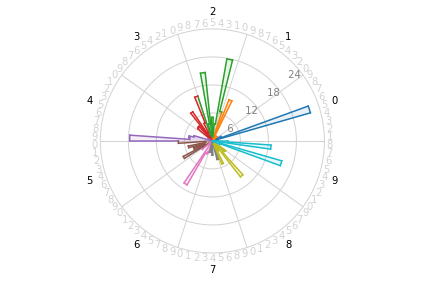

In [7]:
PlotConfusionStar(cm,cl)

**Plot the confusion matrix as a confusion star in log scale**

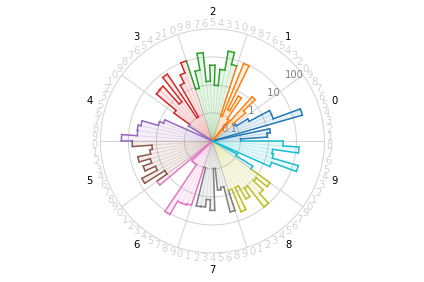

In [8]:
PlotConfusionStar(cm,cl, log=True)

**Plot the confusion matrix as a balanced confusion gear**

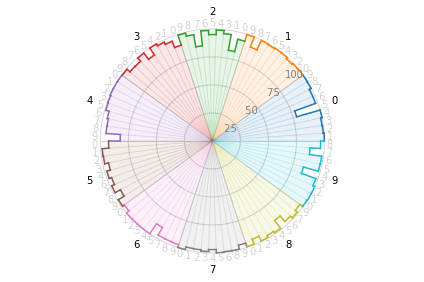

In [9]:
PlotConfusionStar(cm,cl,star=False)

# Plot the Abalon-10 confusion matrix

**Get and print confusion matrix**

In [10]:
cm,cl = GetConfusionMatrix('Abalone-10_cm.xlsx')
print(cm)

[[ 6  5  0  0  0  0  0  0  0  0]
 [ 6  7  7  3  0  0  0  0  0  0]
 [ 0  6 15 26  1  4  0  0  0  0]
 [ 0  1 10 34 23 10  0  0  0  0]
 [ 0  0  2 14 47 39 12  0  0  0]
 [ 0  0  2 12 28 63 27  6  0  0]
 [ 0  0  1  8 14 47 39 18  0  0]
 [ 0  0  1  6  7 30 32 21  0  0]
 [ 0  0  0  0  3 14 18 16  0  2]
 [ 0  0  0  1  2  7 17 13  0  1]]


**Print number of instances per class**

In [11]:
print(np.sum(cm,axis=1))

[ 11  23  52  78 114 138 127  97  53  41]


**Plot the balanced confusion star**

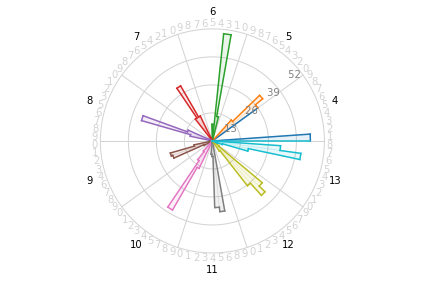

In [12]:
PlotConfusionStar(cm,cl)

**Plot the imbalanced confusion star**

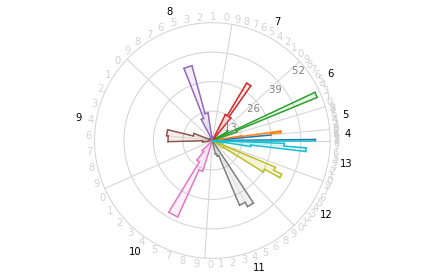

In [13]:
PlotConfusionStar(cm,cl,balanced=False)

# Plot the CIFAR-100 confusion matrix

**Get and print confusion matrix**

In [14]:
cm,cl = GetConfusionMatrix('CIFAR100_cm.xlsx')
print(cm)

[[66  2  0 ...  0  1  0]
 [ 0 55  0 ...  0  0  0]
 [ 2  1 30 ...  0  4  0]
 ...
 [ 0  0  0 ... 39  2  1]
 [ 0  0  7 ...  0 14  1]
 [ 0  0  0 ...  0  0 50]]


**Define the function to plot a colored grid**

In [15]:
def PlotColoredGrid(cm,unit=True,xyticks='full',celltext=True):
    '''Plot a colored grid
    Parameters
    ----------
    cm: confusion matrix of dimension (C,C)
    unit: bool
        A flag used to indicate if the unit confusion matrix has to be obtained
    xyticks: string
        Indicate if the ticks and labels on X and Y axis has to be drawn
        If 'auto', ticks and labels are automatically determined
        If None, ticks and labels are ommited
        If 'full' or any other value, ticks and labels are drawn for every class
    celltext: bool (optional).
        If True the value of each cell is drawn
    '''        
    C = cm.shape[0] #Number of classes
    um = cm2um(cm,unit) #Convert to unit matrix if required
    if unit:
        formato = '{:3.0f}%'
        clim = [0,100]
    else:
        formato = '{:3d}'
        clim = None
    plt.figure()
    ax = plt.gca()
    plt.imshow(um,cmap='Spectral_r',clim=clim)
    if xyticks=='auto':
        ax.xaxis.tick_top()
    elif xyticks==None:
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
    else: #opción elegida también para "full"
        plt.xticks(ticks=range(C))
        ax.xaxis.tick_top()
        plt.yticks(ticks=range(C))
    plt.xlabel('Estimated class')
    plt.ylabel('Actual class')
    ax.xaxis.set_label_position('top') 
    plt.colorbar()
    if celltext:
        for i in range(C):
            for j in range(C):
                t = formato.format(um[i,j])
                plt.text(j,i,t,ha='center',va='center')
    plt.tight_layout()

**Plot the colored grid**

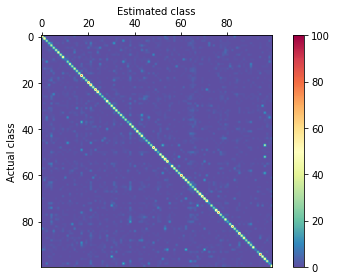

In [16]:
PlotColoredGrid(cm,xyticks='auto',celltext=False)

**Plot the confusion star (it takes some time)**

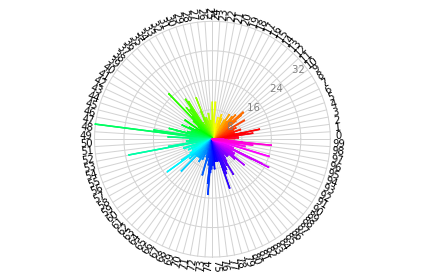

In [17]:
PlotConfusionStar(cm,cl,innerlabel=False,rotoutlabel=True)

# Get a sequence of MNIST confusion matrices

In [18]:
def GetSequenceConfusionMatrices(filename):
    '''Reads an Excel file containing a sequence of confusion matrices
    Parameters
    ----------
    filename : str
        The name of the file
        It has to be an excel file with the following structure:
            - The first row indicates the names of the estimated classes
            - The first column (rows 2 to C+1) indicates the names
                of the actual classes
            - Beginning in the cell (2,2) the first (C,C) confusion matrix
            - Beginning in the cell (C+2,2) the second (C,C) confusion matrix
            - The same structure is repeated for each confusion matrix 
                in the sequence
            
    Returns
    -------
    Lcm : a list of elements 
        Each element is a confusion matrix in the sequence
    '''    
    data = pd.read_excel(filename, index_col=0).values
    n,C = data.shape
    nseq = int(n/C) #Number of matrices in the sequence
    Lcm = [None]*nseq #List of confusion matrices
    for iseq in range(nseq):
        Lcm[iseq] = data[iseq*C:iseq*C+C,:]
    return Lcm

In [19]:
Lcm = GetSequenceConfusionMatrices('MNIST_cm_sequence.xlsx')

# Define the principal function (level 1) to generate a video to visualize a sequence of confusion matrices

In [20]:
import matplotlib.animation as animation

def VideoConfusionStar(filename,Lcm,fps,
                       star=True,balanced=True,log=True,fill=True,
                       edgecolor=None,outerlabel=True,innerlabel=True,
                       rotoutlabel=False,rotinnlabel=False):
    '''Generate a video file visualizing a sequence of confusion matrices
        in the form of confusion stars (or confusion gears)
    Parameters
    ----------
    filename : str
        The name of the file to be generated
        It has to be either a gif or an html file 
    Lcm : a list of elements 
        Each element is a confusion matrix in the sequence
    fps : integer
        Frames per second to generate the video
    star: bool (optional). A flag used to indicate the type of plot
        if True it plots a confusion star
        if False it plots a confusion gear
    balanced: bool (optional).
        A flag used to indicate if the balanced version of the
        confusion star has to be drawn
    log: bool (optional). A flag used to indicate the scale of the plot.
        It only applies to confusion star plots (not to confusion gear plots)
        if True it uses log scale
        if False it uses linear scale
    fill: bool (optional).
        If True the sectors are filled
    edgecolor: color specification or None (optional).
        Star edge color
    outerlabel: bool (optional).
        If True the label of actual classes are drawn
    innerlabel: bool (optional).
        If True the label of indices to estimated classes are drawn
    rotoutlabel: bool (optional).
        If True the label of actual classes are rotated
    rotinnlabel: bool (optional).
        If True the label of indices to estimated classes are rotated
    '''    
    #Common elements of every frame
    fig = plt.figure()
    em,th,beta = GetConfusionStar(Lcm[0],balanced)
    PlotConfusionGrid(em,th,cl,star,log,outerlabel,innerlabel,
                      rotoutlabel,rotinnlabel)
    sectors = GetConfusionSectors(em,th,beta,star,log,fill)
    # Variable part of the frames
    PlotElem = PlotConfusionSectors(sectors,edgecolor) 
    nframes = len(Lcm) #number of frames
    #Generate animation
    print('Generating frame...')
    ani = animation.FuncAnimation(fig, FrameConfusionStar, frames=nframes, blit=True,
                                  fargs=[PlotElem,Lcm,star,balanced,log,fill])
    #Generate video file
    ext = filename.split('.')[1]
    if ext=='gif': #Generate a GIF file
        writer = animation.PillowWriter(fps=fps, bitrate=1800)
    elif ext=='html': #Generate an HTML file
        writer = animation.HTMLWriter(fps=fps, bitrate=1800)
    ani.save(filename, writer=writer)

# Define the auxiliary functions (level 2) required to generate a video to visualize a sequence of confusion matrices

These functions are:
*   FrameConfusionStar
*   UpdateConfusionSectors

In [21]:
def FrameConfusionStar(frame,PlotElem,Lcm,star,balanced,log,fill):
    '''Generate a frame of the to  visualize a sequence of confusion matrices
        in the form of confusion stars (or confusion gears)
    Parameters
    ----------
    frame: integer
        The number of the frame in the sequence
    PlotElem : list containing the following 3 elements
        - PlotElemArc: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            arc corresponding to a sector
        - PlotElemConLin: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            connecting line corresponding to a sector
        - PlotFilledArea: a list containing C·(C-1) elements
            Each element contains a matplotlib Patch Polygon object defining
            the filled area corresponding to a sector
    Lcm : a list of elements 
        Each element is a confusion matrix in the sequence
    star: bool (optional). A flag used to indicate the type of plot
        if True it plots a confusion star
        if False it plots a confusion gear
    balanced: bool (optional).
        A flag used to indicate if the balanced version of the
        confusion star has to be drawn
    log: bool (optional). A flag used to indicate the scale of the plot.
        It only applies to confusion star plots (not to confusion gear plots)
        if True it uses log scale
        if False it uses linear scale
    fill: bool (optional).
        If True the sectors are filled
    Returns
    -------
    PlotElem : list with the same structure that the input parameter
        The information is updated by the function
    '''    
    print('\r',frame,end='')
    em,th,beta = GetConfusionStar(Lcm[frame],balanced)
    sectors = GetConfusionSectors(em,th,beta,star,log,fill)
    PlotElem = UpdateConfusionSectors(PlotElem,sectors)
    return PlotElem


def UpdateConfusionSectors(PlotElem,sectors):
    '''Update the plot of the sectors of a confusion star (or confusion gear)
        These sectors include:
            - The arches (circular)
            - The connecting lines (radial)
            - The filled polygon of each sector
    Parameters
    ----------
    PlotElem : list containing the following 3 elements
        - PlotElemArc: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            arc corresponding to a sector
        - PlotElemConLin: a list containing C·(C-1) elements
            Each element contains a matplotlib Line2D object defining the
            connecting line corresponding to a sector
        - PlotFilledArea: a list containing C·(C-1) elements
            Each element contains a matplotlib Patch Polygon object defining
            the filled area corresponding to a sector
    sectors : list containing the following 5 elements
        - arcx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of an arc
        - arcy: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of an arc
        - conlinx: a list containing C·(C-1) elements
            Each element contains a vector with the x-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - conliny: a list containing C·(C-1) elements
            Each element contains a vector with the y-coordinates of the
            radial line connecting 2 arches: the end of the corresponding arc 
            with the beginning of the next one
        - color: a list containing C·(C-1) elements
            Each element contains the color of the corresponding arc and
            radial connecting line

    Returns
    -------
    PlotElem : list with the same structure that the input parameter
        The information is updated by the function
    '''
    arcx,arcy,conlinx,conliny,color = sectors
    nth = len(arcx) #Number of arches
    nfi = len(arcx[0]) #Number of points to draw each arc
    PlotElemArc = PlotElem[:nth]
    PlotElemConlin = PlotElem[nth:2*nth]
    PlotElemFilledArea = PlotElem[2*nth:3*nth]
    v = np.zeros((nfi+1,2))
    for k in range(nth):
        PlotElemArc[k].set_data(arcx[k],arcy[k])
        PlotElemConlin[k].set_data(conlinx[k], conliny[k])
        v[1:,0] = arcx[k]
        v[1:,1] = arcy[k]
        if np.sum(v)!=0:
            PlotElemFilledArea[k].set_xy(v)
    #Pack all plot elements
    PlotElem = []
    PlotElem.extend(PlotElemArc)
    PlotElem.extend(PlotElemConlin)
    PlotElem.extend(PlotElemFilledArea)    
    return PlotElem

# Generate a video to visualize a sequence of confusion matrices in the form of confusion stars

Generating frame...
 99

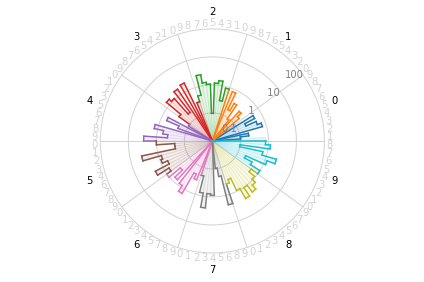

In [22]:
VideoConfusionStar('LearningProcess.gif',Lcm,2,star=True)